# CausalRCA

The original implementation is here. <https://github.com/AXinx/CausalRCA_code/>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

import logging
logger = logging.getLogger()
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [4]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=False,
) 

In [6]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "carts-db")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1].iloc[-40:180,:],
    data_df_by_metric_type["services"][-1].iloc[-40:180, :],
], axis=1)
dataset.shape

(40, 81)

In [7]:
MANUALLY_SELECTED_METRICS: set[str] = {
    "latency",
    "cpu_usage_seconds_total",
    "memory_working_set_bytes",
    "fs_reads_total",
    "fs_writes_total",
    "network_receive_bytes_total",
    "network_transmit_bytes_total",
}

def filter_manually_selected_metrics(df: pd.DataFrame) -> pd.DataFrame:
    # Filter only container metrics
    return df.loc[
        :,
        [
            (not metric_name.startswith("m-") and not metric_name.startswith("n-")) and any([metric_name.endswith(base_name) for base_name in MANUALLY_SELECTED_METRICS])
            for metric_name in df.columns.tolist()
        ],
    ]

dataset = filter_manually_selected_metrics(record.data_df).iloc[-40:180, :]
dataset.shape

(40, 73)

In [8]:
from diagnoser.causalrca import CausalRCA
from diagnoser.daggnn.config import Config

In [12]:
import torch

torch.set_num_threads(1)

params = Config().to_prefixed_dict(prefix="causalrca")
conf = Config.from_prefixed_dict(prefix="causalrca", **params)
print(conf)
causalrca = CausalRCA(dataset, conf)
graph_adj, elapsed = causalrca.fit()

Config(epochs=1000, batch_size=120, lr=0.001, x_dims=1, z_dims=1, optimizer='Adam', graph_threshold=0.3, tau_A=0.0, lambda_A=0.0, c_A=1, c_A_ul=10000000000.0, use_A_connect_loss=0, use_A_positiver_loss=0, cuda=False, seed=42, encoder_hidden=64, decoder_hidden=64, temp=0.5, k_max_iter=10.0, encoder='mlp', decoder='mlp', encoder_dropout=0.0, decoder_dropout=0.0, h_tol=1e-08, lr_decay=200, sche_gamma=1.0, prior=False, factor=True, eta=10, gamma=0.25)
Step: 1/10, Best Epoch: 926/1000, ELBO Loss: 2940759675267.7656, NLL Loss: 47249.13298439967, MSE Loss: 1294.4967940931417
Step: 2/10, Best Epoch: 952/1000, ELBO Loss: 1090259231946.644, NLL Loss: 2029.901749735908, MSE Loss: 55.61374656810707
Step: 3/10, Best Epoch: 983/1000, ELBO Loss: 846348007383.2378, NLL Loss: 503.2158516648875, MSE Loss: 13.786735662051711
Step: 4/10, Best Epoch: 929/1000, ELBO Loss: 846348007383.2378, NLL Loss: 158.92850981744496, MSE Loss: 4.35420574842315
Step: 5/10, Best Epoch: 874/1000, ELBO Loss: 153135372237.227

{61: ('c-user_fs_writes_total', 0.04575321),
 43: ('c-orders-db_fs_writes_total', 0.040909786),
 24: ('c-front-end_fs_reads_total', 0.038465302),
 14: ('c-catalogue_cpu_usage_seconds_total', 0.037617296),
 68: ('s-front-end_latency', 0.03607466),
 67: ('s-catalogue_latency', 0.033241987),
 1: ('c-carts_fs_writes_total', 0.032974415),
 30: ('c-orders_fs_reads_total', 0.03127421),
 60: ('c-user_fs_reads_total', 0.031242818),
 70: ('s-payment_latency', 0.02902575),
 54: ('c-payment_fs_reads_total', 0.028964644),
 71: ('s-shipping_latency', 0.028908027),
 72: ('s-user_latency', 0.028238617),
 49: ('c-user-db_fs_writes_total', 0.02654809),
 69: ('s-orders_latency', 0.026117908),
 19: ('c-catalogue-db_fs_writes_total', 0.025474142),
 32: ('c-orders_cpu_usage_seconds_total', 0.025378292),
 0: ('c-carts_fs_reads_total', 0.024538882),
 13: ('c-catalogue_fs_writes_total', 0.0235968),
 26: ('c-front-end_cpu_usage_seconds_total', 0.02284354),
 56: ('c-payment_cpu_usage_seconds_total', 0.022402707)

In [22]:
ranks = causalrca.rank(graph_adj)
ranks

{61: ('c-user_fs_writes_total', 0.04592838076889948),
 43: ('c-orders-db_fs_writes_total', 0.04117798651253209),
 24: ('c-front-end_fs_reads_total', 0.038899711213167265),
 14: ('c-catalogue_cpu_usage_seconds_total', 0.03814208904558303),
 68: ('s-front-end_latency', 0.036143673960599754),
 1: ('c-carts_fs_writes_total', 0.03347113965982233),
 67: ('s-catalogue_latency', 0.03328495393773244),
 30: ('c-orders_fs_reads_total', 0.03154692949444585),
 60: ('c-user_fs_reads_total', 0.031379796291267796),
 54: ('c-payment_fs_reads_total', 0.029156970444537647),
 70: ('s-payment_latency', 0.029027828907701565),
 71: ('s-shipping_latency', 0.028876601973209334),
 72: ('s-user_latency', 0.028146161069620312),
 49: ('c-user-db_fs_writes_total', 0.0265935244880261),
 69: ('s-orders_latency', 0.02609201296584869),
 19: ('c-catalogue-db_fs_writes_total', 0.025664928485946294),
 32: ('c-orders_cpu_usage_seconds_total', 0.025579190408101374),
 0: ('c-carts_fs_reads_total', 0.024816074566661336),
 13:

[]

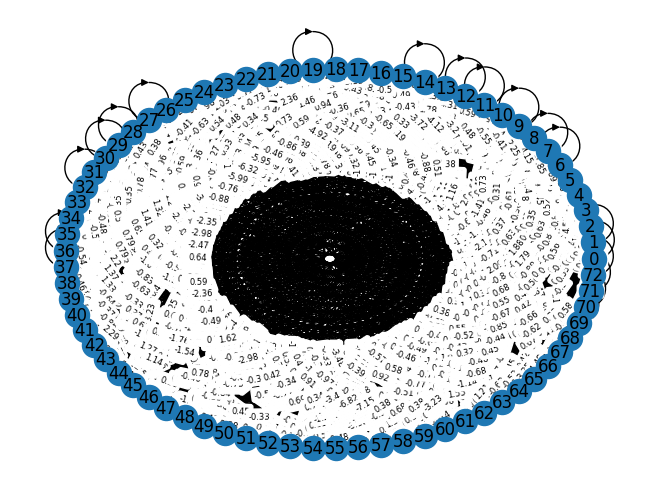

In [10]:
import networkx as nx

graph_adj[np.abs(graph_adj) < 0.3] = 0
org_G = nx.DiGraph(graph_adj)
pos=nx.circular_layout(org_G)
nx.draw(org_G, pos=pos, with_labels=True)
edge_labels = {k: round(w, 2) for k, w in nx.get_edge_attributes(org_G, "weight").items()}
nx.draw_networkx_edge_labels(org_G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.25)
plt.plot()

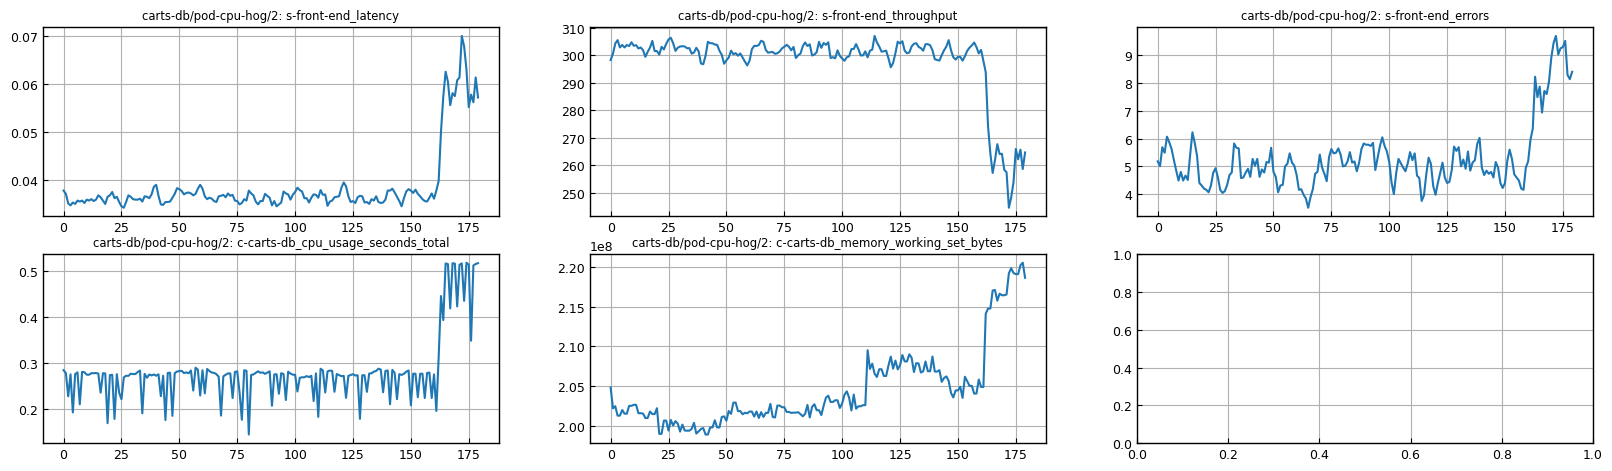

In [11]:
from notebooklib import plot

plot.plot_sli_and_causal_metrics(dataset, record)
# plot.plot_dataset_dataframe(dataset, record)